In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
ImageFile.LOAD_TRUNCATED_IMAGES = True
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import torch.onnx
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.transforms import Resize, CenterCrop, Pad, Compose
import torchvision.transforms.functional as F

c:\Users\Admin\.virtualenvs\AR_classification-AOelGpcL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import open_clip

model_name = 'coca_ViT-L-14' #'ViT-L-14-CLIPA'
pretrained = 'mscoco_finetuned_laion2b_s13b_b90k' #'datacomp1b'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained=pretrained)

In [3]:
# from clip_onnx import clip_onnx
# from utils import attention

# # onnx cannot export with cuda
# #model, preprocess = clip.load("ViT-B/32", device="cpu", jit=False)

# # batch first
# image = preprocess(Image.open("./dataset/queries/1.jpeg")).unsqueeze(0).to(device) # [1, 3, 224, 224]
# image_onnx = image.detach().cpu().numpy().astype(np.float32)


In [4]:
# visual_path = "clip_visual.onnx"
# textual_path = "clip_textual.onnx"

# onnx_model = clip_onnx(model, visual_path=visual_path)
# onnx_model.convert2onnx(image,verbose=True)
# # ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
# onnx_model.start_sessions(providers=["CPUExecutionProvider"]) # cpu mode

In [5]:
# print(image_onnx.shape)

In [6]:
# image_features = onnx_model.encode_image(image_onnx)


# logits_per_image = onnx_model(image_onnx)
# probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421067 0.00299571]]

In [7]:
# image_input = torch.randn(1, 3, 224, 224).to(device)
# torch.onnx.export(model, (image_input), "clip_model.onnx", opset_version=14)

In [8]:
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x0000025DEF5CE320>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [9]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [10]:
base_dir = './dataset/'
src_dir = base_dir + '/test_tran'
query_dir = base_dir + '/queries'
preprocess_dir = base_dir + '/preprocess'
submission = pd.read_csv(base_dir+ '/sample_submission.csv')

In [11]:
query_classes = []
q_batch =  []
#print(preprocess)
# Define transforms for each augmentation
preprocess_original = preprocess  # Your original preprocess function for clear RGB images
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    preprocess
])
preprocess_blur = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    preprocess
])
preprocess_zoom_out = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    # Step 1: Resize the image to make it smaller than the model's expected input dimensions
    transforms.Resize(180),  # Assuming the original input size is 256x256, adjust this value as needed
    # Step 2: Pad the resized image to match the model's expected input dimensions
    # The padding mode can be changed as needed (e.g., 'constant', 'edge', 'reflect')
    lambda img: F.pad(img, padding=(38, 38, 38, 38), padding_mode='constant', fill=0),
    # Step 3: Apply your model-specific preprocessing (e.g., normalization)
    preprocess
])
preprocess_sharpness = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(contrast=(1,2)),
    preprocess
])

preprocess_affine1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9)),
    preprocess
])
tic = time.perf_counter()
for file in os.listdir(query_dir):
    class_id = int(file[:-5])  # Assuming the class ID is in the filename
    count = 0    
    # Load image
    img_path = os.path.join(query_dir, file)
    image = Image.open(img_path).convert('RGB')
    # # Apply each augmentation and append to q_batch
    ori_pil = transforms.ToPILImage()(preprocess_original(image)) 
    gray_pil = transforms.ToPILImage()(preprocess_grayscale(image))
    blur_pil = transforms.ToPILImage()(preprocess_blur(image)) 
    zout_pil = transforms.ToPILImage()(preprocess_zoom_out(image))
    ori_pil.save(preprocess_dir+f'/{class_id}_1.jpeg')
    gray_pil.save(preprocess_dir+f'/{class_id}_2.jpeg')
    blur_pil.save(preprocess_dir+f'/{class_id}_3.jpeg')
    zout_pil.save(preprocess_dir+f'/{class_id}_4.jpeg')
    
      
    q_batch.append(preprocess_original(image))  # Original clear RGB image
    q_batch.append(preprocess_grayscale(image))  # Grayscale
    q_batch.append(preprocess_blur(image))  # Blurred
    q_batch.append(preprocess_zoom_out(image))
    #q_batch.append(preprocess_sharpness(image))#zoom-out
    #q_batch.append(preprocess_affine1(image))
    count = count + 4
    # Replicate class ID for each augmented image version
    query_classes.extend([class_id] * count)# 4 versions of each image

# Stack all processed images into a tensor
q_batch_transformed = torch.stack(q_batch, dim=0).to(device)
print(query_classes)
print(q_batch_transformed.shape)  # Check the shape, should be 4x larger in the first dimension

# Generate embeddings
with torch.no_grad():
    q_embeddings = model.encode_image(q_batch_transformed).cpu()
    q_embeddings /= q_embeddings.norm(dim=-1, keepdim=True)
toc = time.perf_counter()
print(f"Preprocess in {toc - tic:0.4f} seconds")
print(type(q_embeddings))
#torch.save(model.state_dict(), 'openclip_test.pth')
#print(q_embeddings.shape)

c:\Users\Admin\.virtualenvs\AR_classification-AOelGpcL\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1, 1, 1, 1, 10, 10, 10, 10, 100, 100, 100, 100, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 2, 2, 2, 2, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 3, 3, 3, 3, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 4, 4, 4, 4, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 5, 5, 5, 5, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 6, 6, 6, 6, 60, 60, 60, 60, 61, 61, 61, 61, 62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66,

In [12]:
# Export tensor to a pickle file
print(q_embeddings.shape)
with open('tensor.pkl', 'wb') as f:
    pickle.dump(q_embeddings, f)
with open('class.pkl', 'wb') as d:
    pickle.dump(query_classes, d)


torch.Size([400, 768])


In [13]:
# Import tensor from pickle file
with open('tensor.pkl', 'rb') as f:
    q_embeddings = pickle.load(f)
with open('class.pkl', 'rb') as d:
    query_classes = pickle.load(d)

# Print the loaded tensor
print(q_embeddings.shape)
print(query_classes)

torch.Size([400, 768])
[1, 1, 1, 1, 10, 10, 10, 10, 100, 100, 100, 100, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 2, 2, 2, 2, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 3, 3, 3, 3, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 4, 4, 4, 4, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 5, 5, 5, 5, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 6, 6, 6, 6, 60, 60, 60, 60, 61, 61, 61, 61, 62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, 64, 65, 

torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6538)


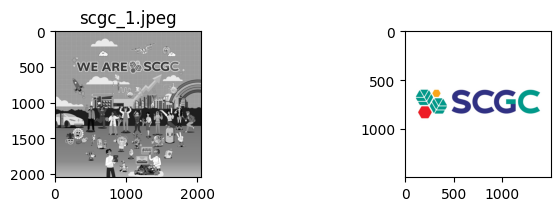

Preprocess in 0.8655 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5867)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


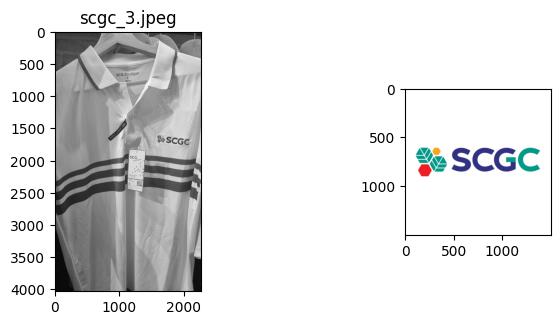

Preprocess in 0.8116 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6521)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


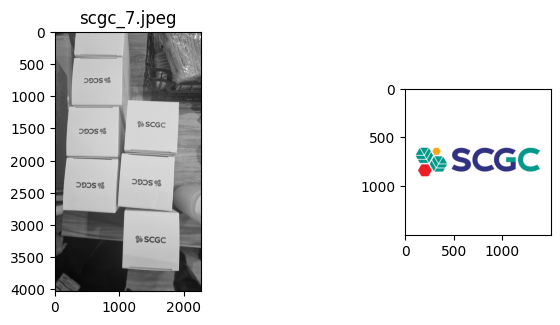

Preprocess in 0.7975 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6158)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


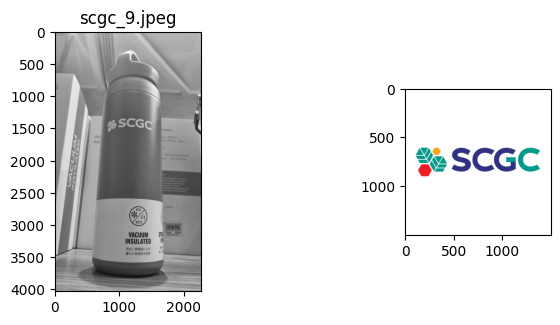

Preprocess in 0.8317 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7654)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


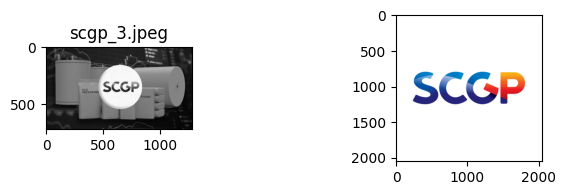

Preprocess in 0.4706 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5852)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


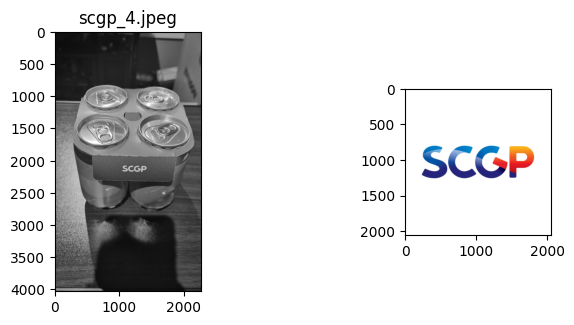

Preprocess in 0.9324 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor(0.5892)


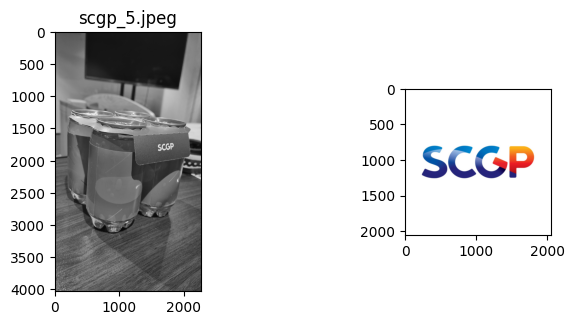

Preprocess in 0.9927 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.5408)


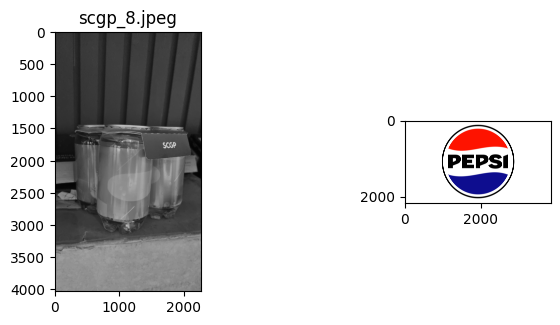

Preprocess in 1.0329 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.5045)


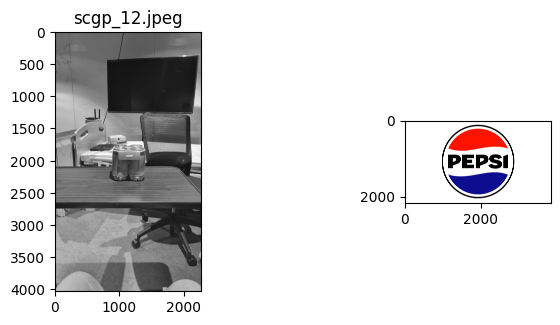

Preprocess in 1.0339 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8688)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


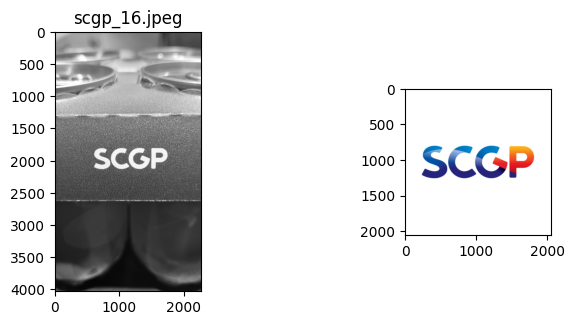

Preprocess in 0.9475 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8019)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


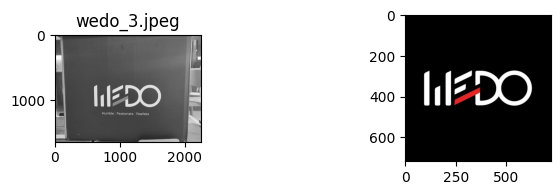

Preprocess in 0.6689 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6295)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


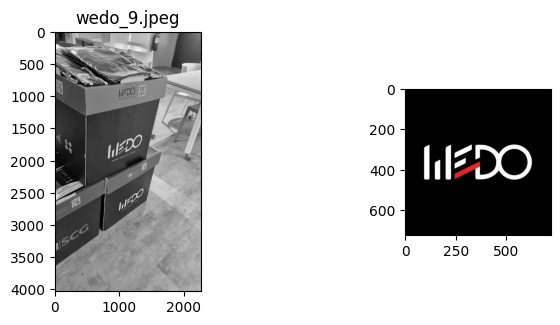

Preprocess in 0.7208 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5723)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


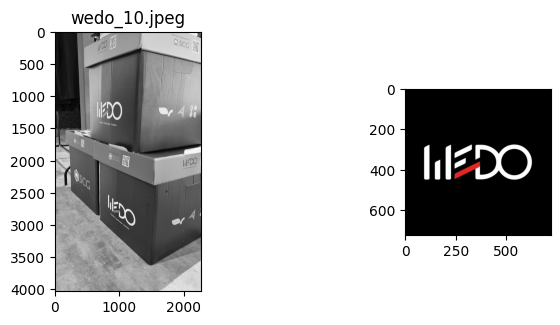

Preprocess in 0.7164 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6093)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


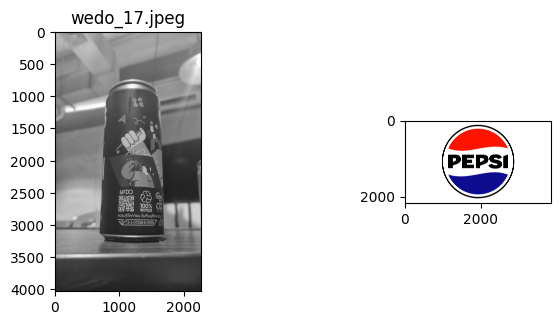

Preprocess in 0.9904 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6151)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


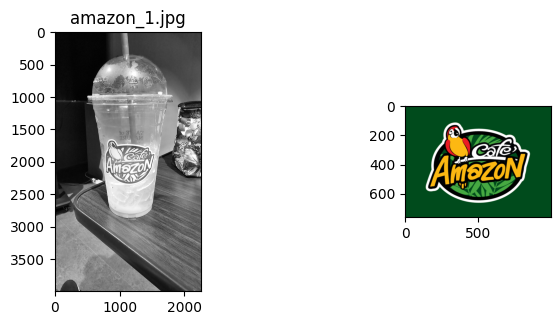

Preprocess in 0.7200 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6204)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


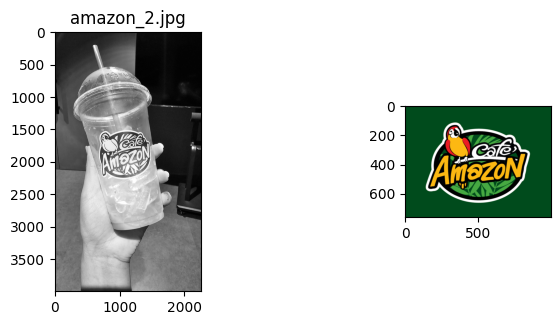

Preprocess in 0.7065 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6323)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


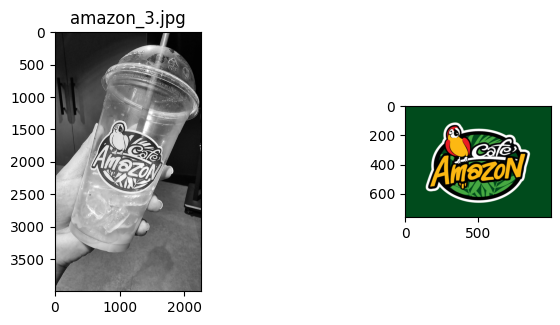

Preprocess in 0.7119 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6625)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


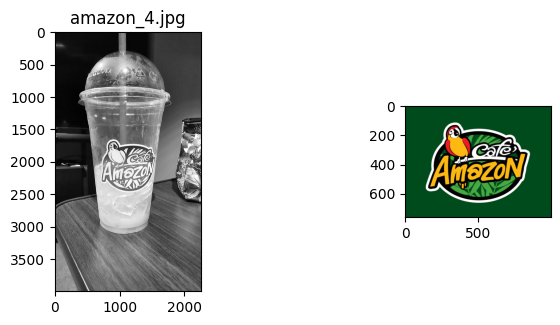

Preprocess in 0.7245 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5418)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


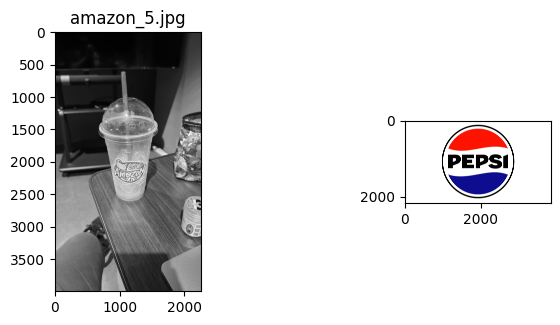

Preprocess in 0.9310 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6822)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


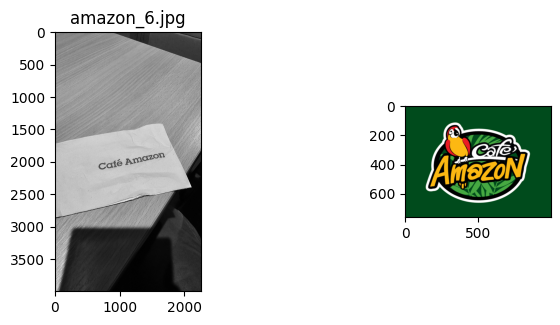

Preprocess in 0.7108 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7173)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


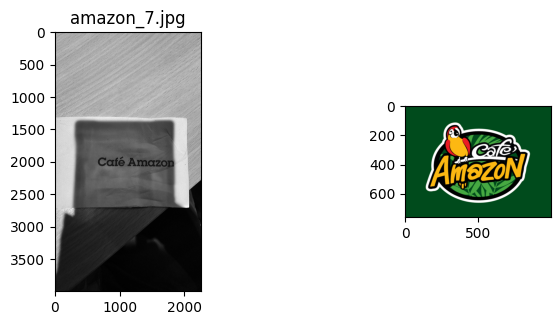

Preprocess in 0.7373 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6852)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


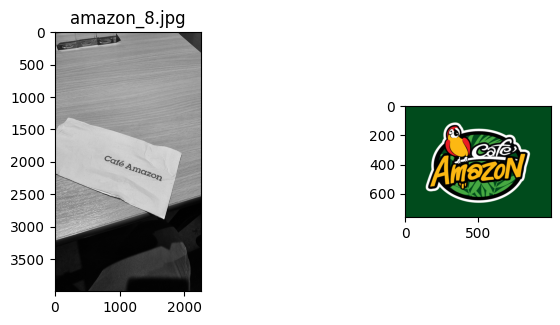

Preprocess in 0.6917 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6806)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


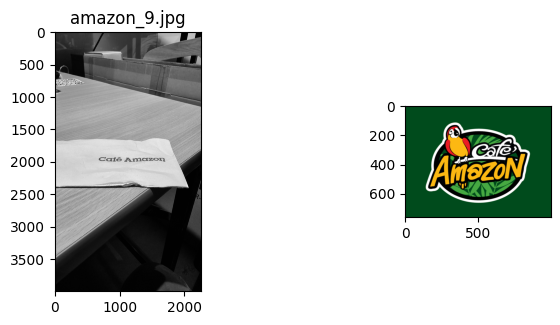

Preprocess in 0.7360 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5405)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


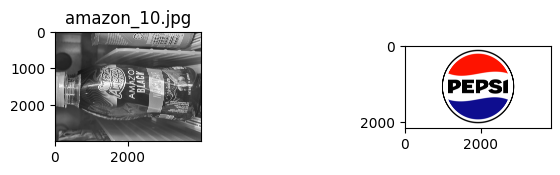

Preprocess in 0.9118 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8385)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


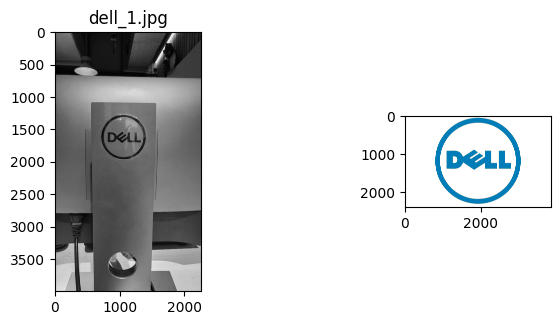

Preprocess in 0.8891 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8782)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


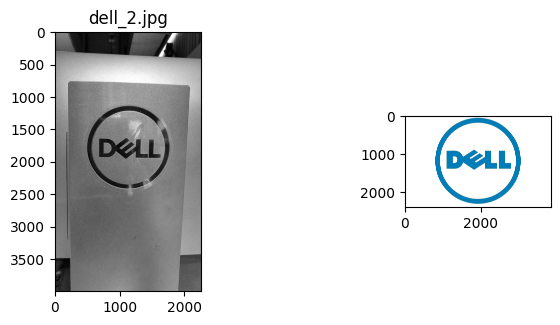

Preprocess in 0.8839 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7938)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


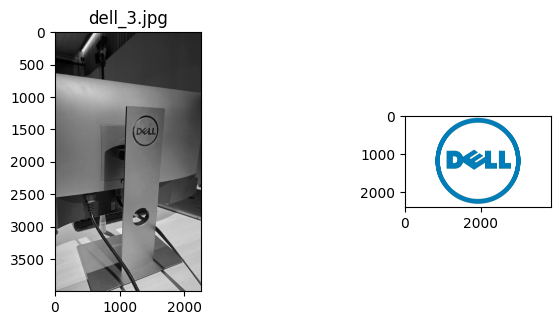

Preprocess in 1.0332 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8186)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


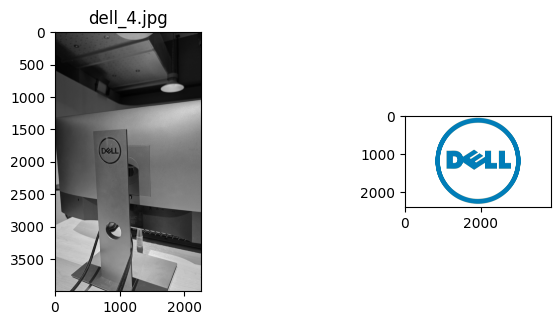

Preprocess in 0.9315 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8001)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


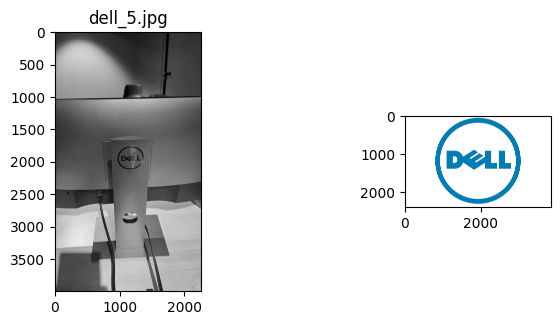

Preprocess in 0.8762 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7960)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


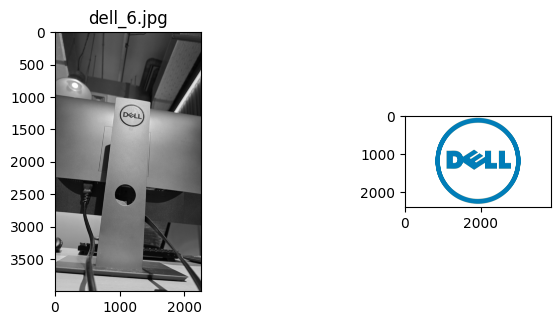

Preprocess in 0.8898 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7530)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


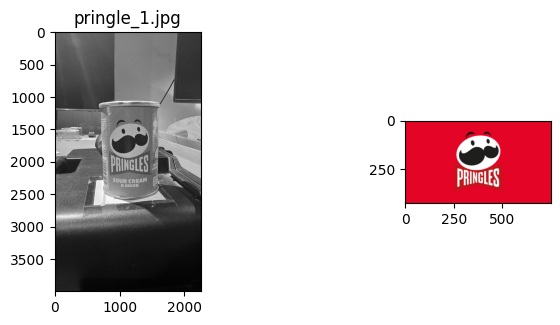

Preprocess in 0.6705 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6242)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


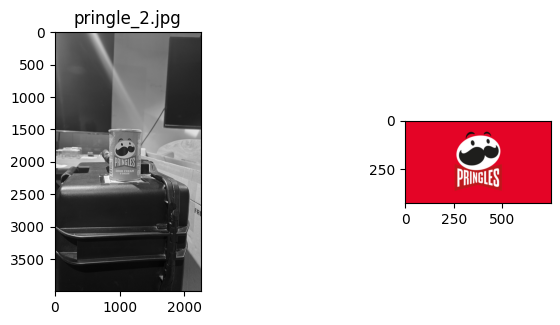

Preprocess in 0.6824 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7721)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


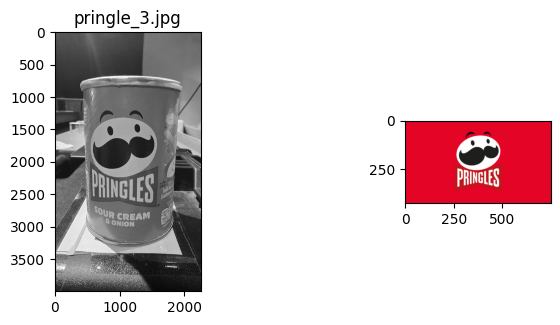

Preprocess in 0.7308 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.6558)


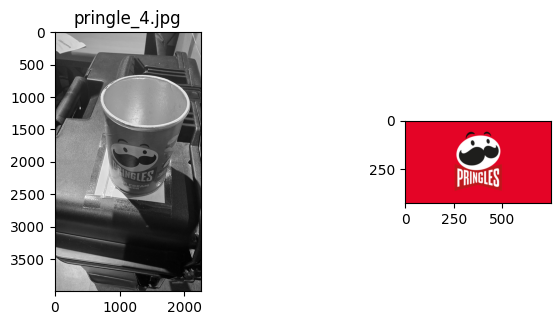

Preprocess in 0.7600 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7164)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


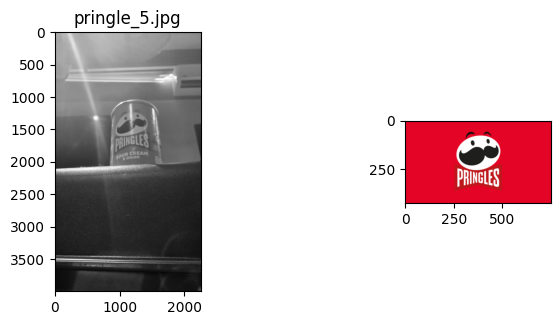

Preprocess in 0.6421 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7043)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


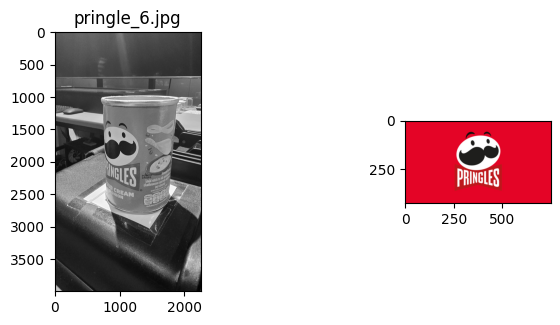

Preprocess in 0.7158 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6170)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


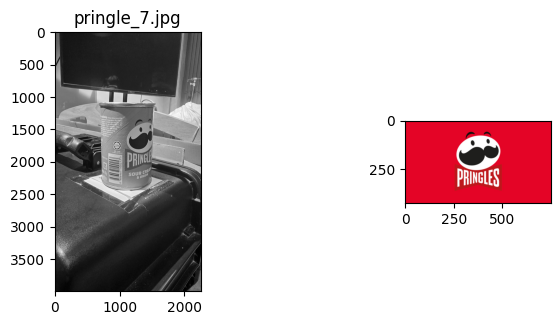

Preprocess in 0.6844 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.9243)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


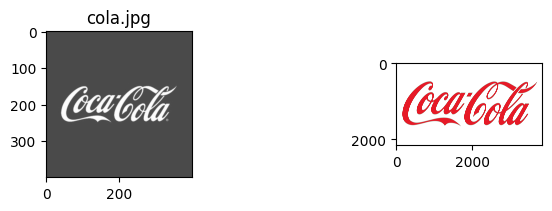

Preprocess in 0.4168 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6392)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


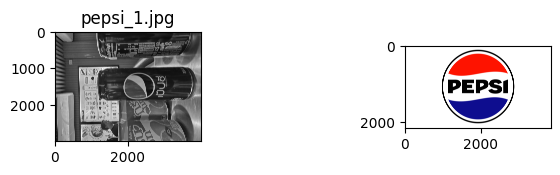

Preprocess in 0.9542 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.6537)


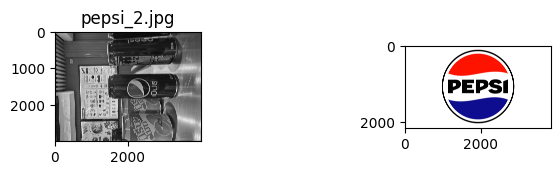

Preprocess in 1.0054 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6554)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


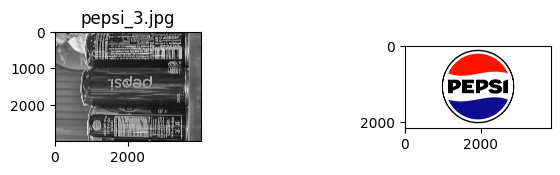

Preprocess in 0.9668 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7963)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


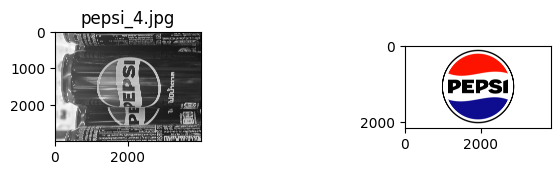

Preprocess in 0.9018 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


tensor(0.6107)


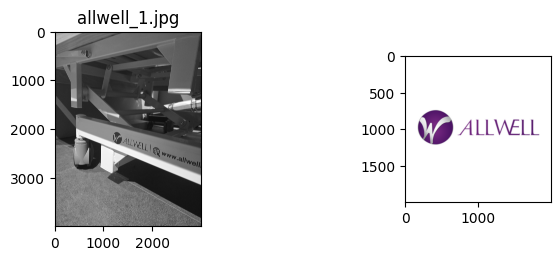

Preprocess in 0.9589 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.8111)


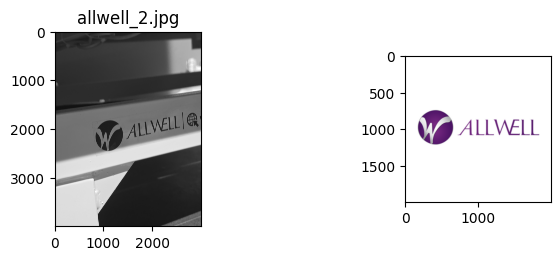

Preprocess in 0.9680 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8168)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


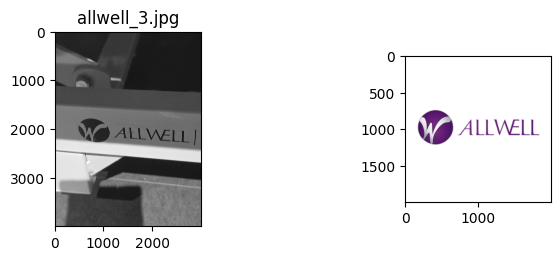

Preprocess in 0.9135 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7803)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


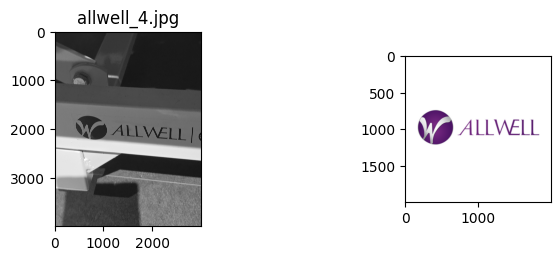

Preprocess in 0.9230 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.8340)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


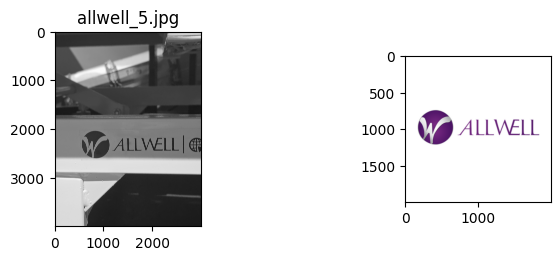

Preprocess in 1.0939 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7175)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


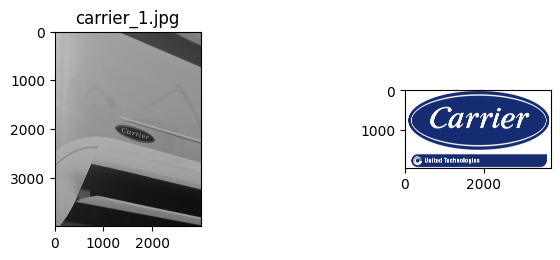

Preprocess in 0.8995 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.6837)


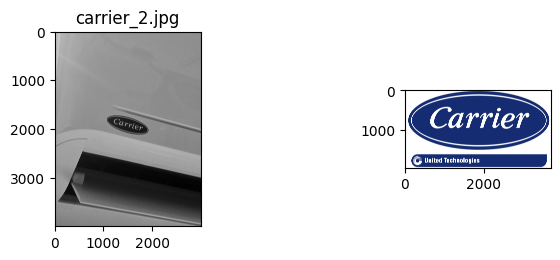

Preprocess in 0.9537 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7590)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


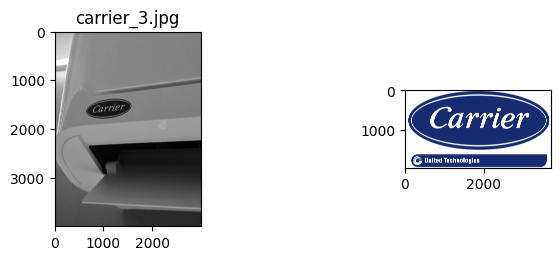

Preprocess in 0.9909 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7174)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


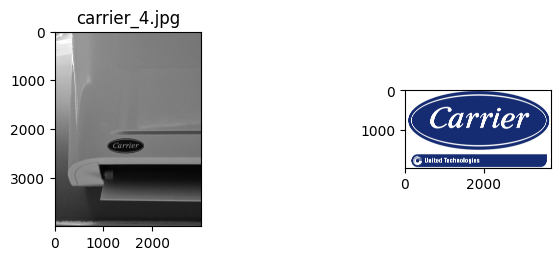

Preprocess in 0.9649 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.7649)


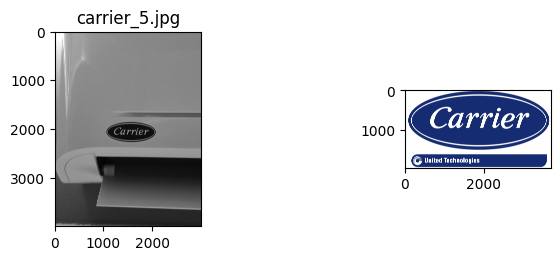

Preprocess in 0.9884 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7408)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


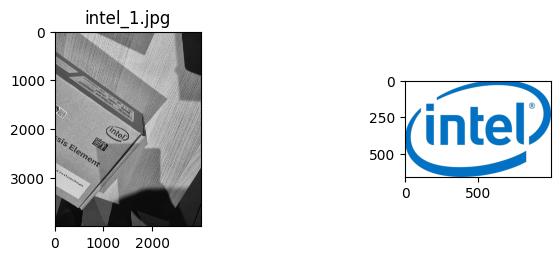

Preprocess in 0.7682 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5970)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


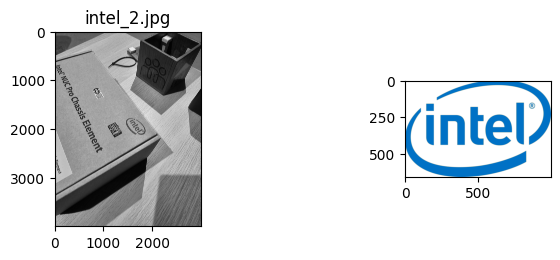

Preprocess in 0.7125 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6817)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


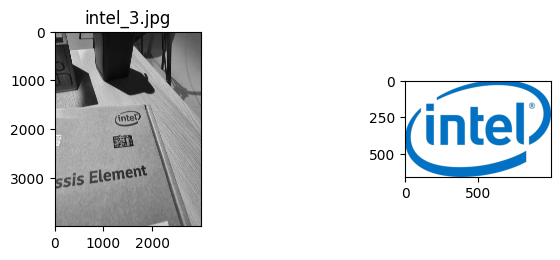

Preprocess in 0.7496 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.7633)


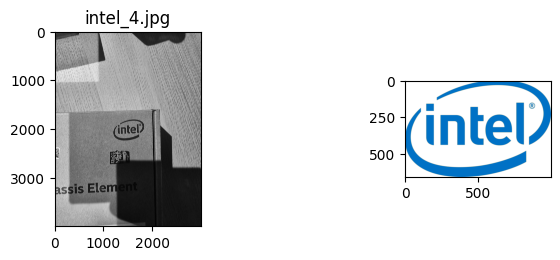

Preprocess in 0.7532 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5574)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


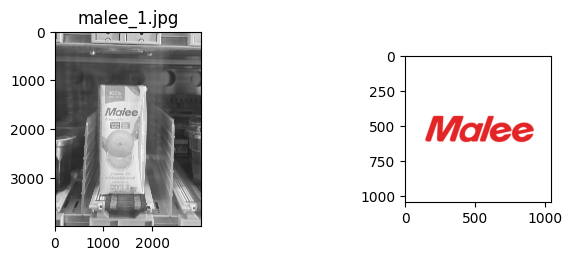

Preprocess in 0.7332 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.4908)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


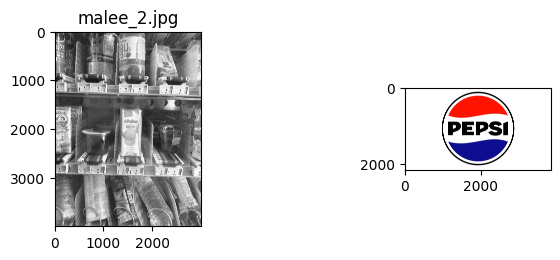

Preprocess in 1.0246 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.5080)


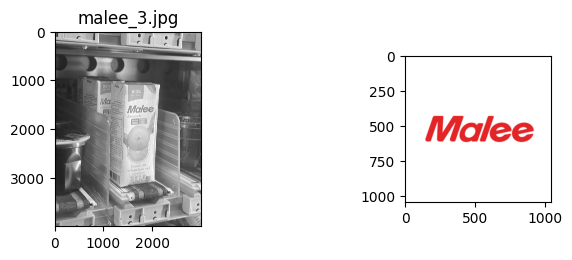

Preprocess in 0.8762 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5102)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


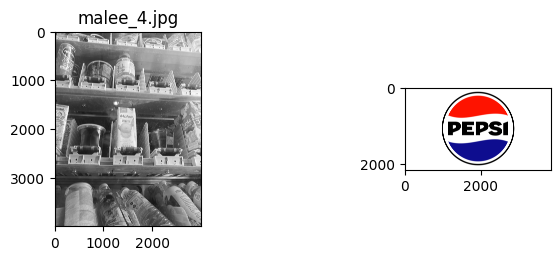

Preprocess in 0.9939 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.4578)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


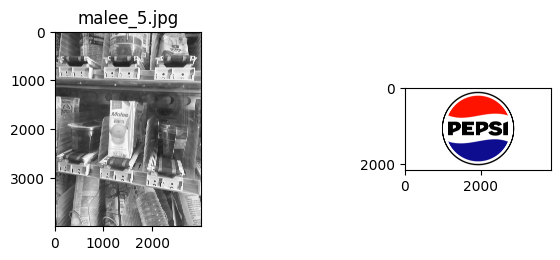

Preprocess in 0.9970 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6316)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


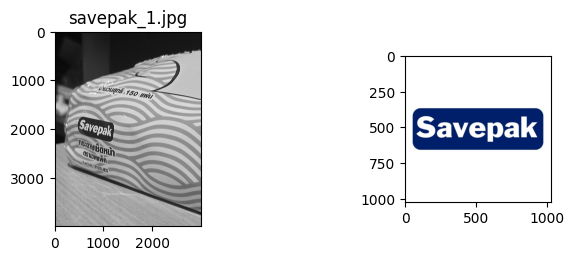

Preprocess in 0.8204 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.6192)


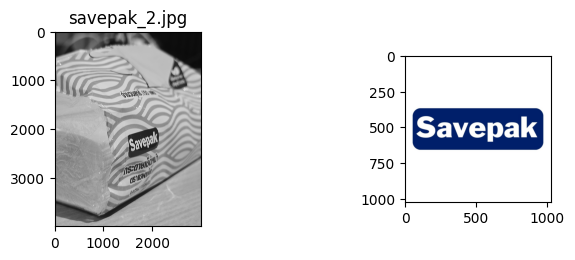

Preprocess in 0.8324 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6806)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


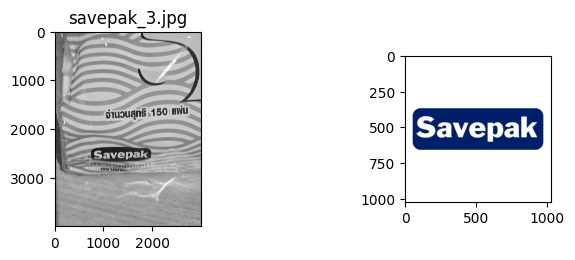

Preprocess in 0.8201 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6230)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


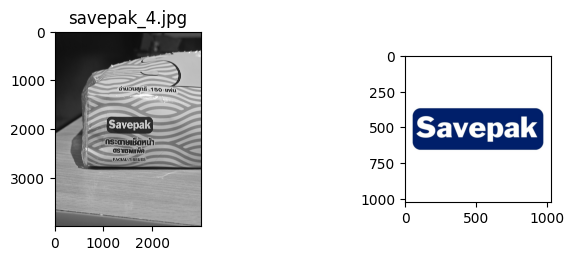

Preprocess in 0.8064 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5856)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


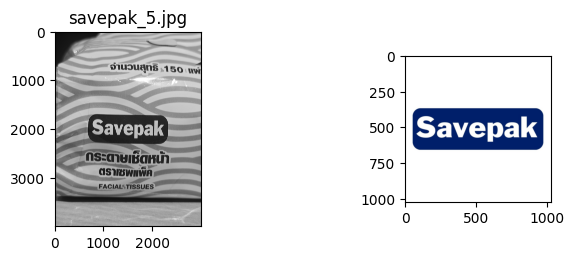

Preprocess in 0.9896 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.7406)


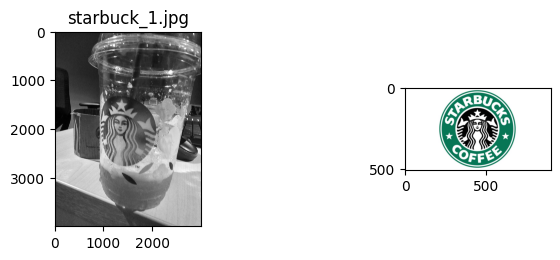

Preprocess in 0.8280 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.7214)


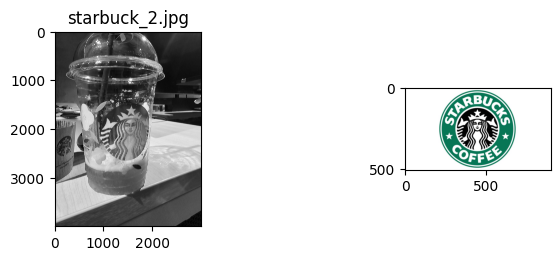

Preprocess in 0.7745 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.7560)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


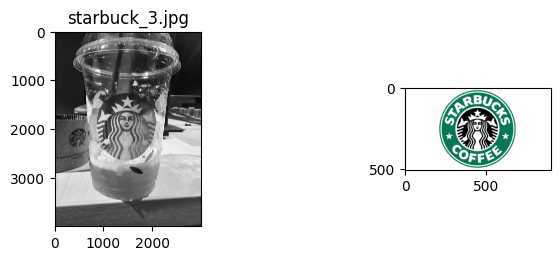

Preprocess in 0.7354 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.7392)


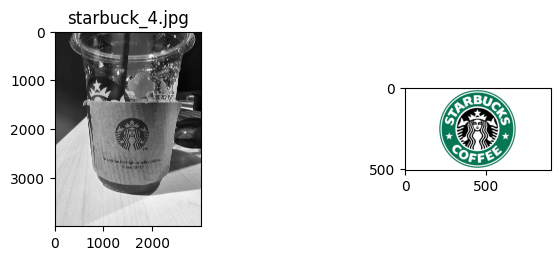

Preprocess in 0.8369 seconds
torch.Size([1, 3, 224, 224])


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


torch.Size([1, 768])
tensor(0.5857)


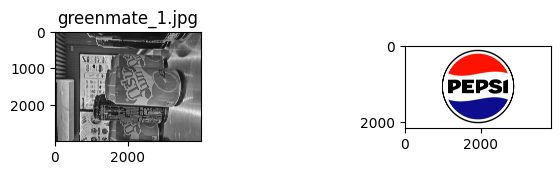

Preprocess in 0.9729 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.5616)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


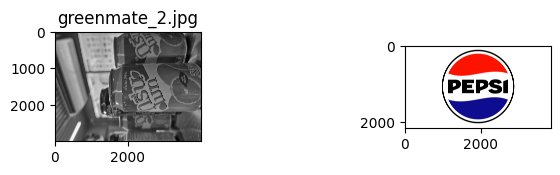

Preprocess in 0.9157 seconds
torch.Size([1, 3, 224, 224])
torch.Size([1, 768])
tensor(0.6121)


C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


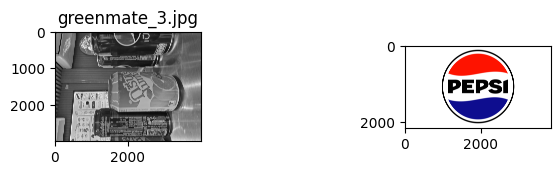

Preprocess in 0.9017 seconds
           img_file  class  dot_class  Predicted  cosine_class  \
0       scgc_1.jpeg      1        101       SCGC             1   
1       scgc_3.jpeg      1        101       SCGC             1   
2       scgc_7.jpeg      1        101       SCGC             1   
3       scgc_9.jpeg      1        101       SCGC             1   
4       scgp_3.jpeg      2        101       SCGP             2   
..              ...    ...        ...        ...           ...   
68   starbuck_3.jpg     15        101  STARBUCKS            15   
69   starbuck_4.jpg     15        101  STARBUCKS            15   
70  greenmate_1.jpg     28        101      PEPSI            20   
71  greenmate_2.jpg     28        101      PEPSI            20   
72  greenmate_3.jpg     28        101      PEPSI            20   

    minkowski_class  
0               101  
1               101  
2               101  
3               101  
4               101  
..              ...  
68              101  
69

C:\Users\Admin\AppData\Local\Temp\ipykernel_39140\729010545.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['class'] = submission['Predicted']


In [15]:
# test images
from config import *
submission['dot_class'] = 101
submission['cosine_class'] = 101
submission['minkowski_class'] = 101
submission['Predicted'] = 'None'
with torch.no_grad():
    for idx, row in submission.iterrows():
        tic = time.perf_counter()
        #print(row)
        # image = Image.open(os.path.join(src_dir, row['img_file'])).convert('RGB')
        # to grayscale
        image = Image.open(os.path.join(src_dir, row['img_file'])).convert('L')  # Convert to grayscale
        image = image.convert('RGB')  # Convert back to RGB by replicating channels

        # embedding
        inputs = preprocess(image).to(device)
        inputs = inputs.unsqueeze(0)
        print(inputs.shape)
        outputs = model.encode_image(inputs).cpu()
        outputs = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        print(outputs.shape)
        #print(outputs.softmax(1))
        # compute similarity with query
        #print(outputs.shape, q_embeddings.T.shape)
        values = outputs @ q_embeddings.T
        #values = outputs @ q_embeddings.T
        #print(values)
        #print(values.softmax(1))
        # print(values.softmax(1).max())
        # thre_dot = 0.01 
        # if values.softmax(1).max() > thre_dot:
        #     dot_class = query_classes[values.argmax().numpy().tolist()]
        #     submission.at[idx, 'dot_class'] = dot_class
            
        # else:
        #     dot_class = 101

        cosine = torch.cosine_similarity(outputs, q_embeddings)
        #print(cosine)
        print(cosine.max())
        thre_cosine = 0.1 #0.8
        if cosine.max() > thre_cosine:  #0.8
            cosine_class = query_classes[cosine.argmax().numpy().tolist()]
            submission.at[idx, 'cosine_class'] = cosine_class
            submission.at[idx, 'Predicted'] = LABEL[cosine_class]
        else:
            cosine_class = 101

        # # display result for 50 images
        if 0 <= idx < 100:
            plt.subplot(1,3,1)
            plt.title(row['img_file'])
            plt.imshow(image)
            # plt.subplot(1,3,2)
            # if dot_class != 101:
            #     plt.imshow(Image.open(os.path.join(query_dir, str(dot_class) + '.jpeg')))
            plt.subplot(1,3,3)
            if cosine_class != 101:
                plt.imshow(Image.open(os.path.join(query_dir, str(cosine_class) + '.jpeg')))
            plt.show()
        toc = time.perf_counter()
        print(f"Preprocess in {toc - tic:0.4f} seconds")

        sub = submission[['img_file',]]
    #     sub['class'] = submission['dot_class']
    #     sub.to_csv(root + model_name + '-' + pretrained + '_dot_product_than'+ str(thre_dot).replace('.', '-') +'-aug04.csv', index=False)
        sub['class'] = submission['Predicted']
        sub.to_csv('for_submission.csv', index=False)
    print(submission)